# Introduction to Seq2Seq Networks using Pytorch

https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import random
import math
import time

In [53]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [54]:
!python -m spacy download en
!python -m spacy download de

You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [55]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [56]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [57]:
SRC = Field(tokenize=tokenize_de,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True,
            batch_first=True)

TRG = Field(tokenize=tokenize_en,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True,
            batch_first=True)

In [58]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),
                                                    fields=(SRC, TRG))

In [59]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
batch_size = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    device=device)

# CONVOLUCAO

In [71]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #create position tensor
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [0, 1, 2, 3, ..., src len - 1]
        
        #pos = [batch size, src len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, src len, emb dim]
        
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, src len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, src len]
        
        #begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #conved = [batch size, 2 * hid dim, src len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #conved = [batch size, hid dim, src len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        #conved = [batch size, src len, emb dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        
        #combined = [batch size, src len, emb dim]
        
        return conved, combined

In [82]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        #conved_emb = [batch size, trg len, emb dim]
        
        combined = (conved_emb + embedded) * self.scale
        
        #combined = [batch size, trg len, emb dim]
                
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        #energy = [batch size, trg len, src len]
        
        attention = F.softmax(energy, dim=2)
        
        #attention = [batch size, trg len, src len]
            
        attended_encoding = torch.matmul(attention, encoder_combined)
        
        #attended_encoding = [batch size, trg len, emd dim]
        
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        #create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, trg len, emb dim]
        
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
        
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)

            #conved = [batch size, 2 * hid dim, trg len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
         
        #conved = [batch size, trg len, emb dim]
            
        output = self.fc_out(self.dropout(conved))
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [83]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

In [84]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [85]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,351,685 trainable parameters


In [86]:
#def init_weights(m):
#    for name, param in m.named_parameters():
#        if 'weight' in name:
#            nn.init.normal_(param.data, mean=0, std=0.01)
#        else:
#            nn.init.constant_(param.data, 0)
#            
#model.apply(init_weights)

In [87]:
optimizer = optim.Adam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [88]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [89]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [90]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [91]:
filename = 'tut5-model.pt'
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 44s
	Train Loss: 4.359 | Train PPL:  78.154
	 Val. Loss: 3.221 |  Val. PPL:  25.065
Epoch: 02 | Time: 0m 45s
	Train Loss: 3.210 | Train PPL:  24.773
	 Val. Loss: 2.460 |  Val. PPL:  11.707
Epoch: 03 | Time: 0m 45s
	Train Loss: 2.710 | Train PPL:  15.029
	 Val. Loss: 2.173 |  Val. PPL:   8.787
Epoch: 04 | Time: 0m 46s
	Train Loss: 2.455 | Train PPL:  11.641
	 Val. Loss: 2.031 |  Val. PPL:   7.621
Epoch: 05 | Time: 0m 46s
	Train Loss: 2.294 | Train PPL:   9.914
	 Val. Loss: 1.939 |  Val. PPL:   6.949
Epoch: 06 | Time: 0m 46s
	Train Loss: 2.181 | Train PPL:   8.852
	 Val. Loss: 1.889 |  Val. PPL:   6.615
Epoch: 07 | Time: 0m 46s
	Train Loss: 2.090 | Train PPL:   8.083
	 Val. Loss: 1.841 |  Val. PPL:   6.305
Epoch: 08 | Time: 0m 46s
	Train Loss: 2.022 | Train PPL:   7.551
	 Val. Loss: 1.816 |  Val. PPL:   6.148
Epoch: 09 | Time: 0m 46s
	Train Loss: 1.967 | Train PPL:   7.151
	 Val. Loss: 1.791 |  Val. PPL:   5.997
Epoch: 10 | Time: 0m 46s
	Train Loss: 1.924 | Train PPL

In [94]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.817 | Test PPL:   6.154 |


In [102]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [107]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [108]:
example_idx = 9

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'mann', 'in', 'einer', 'weste', 'sitzt', 'auf', 'einem', 'stuhl', 'und', 'hält', 'magazine', '.']
trg = ['a', 'man', 'in', 'a', 'vest', 'is', 'sitting', 'in', 'a', 'chair', 'and', 'holding', 'magazines', '.']


In [109]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'man', 'in', 'a', 'vest', 'sits', 'on', 'a', 'chair', 'holding', '<unk>', '.', '<eos>']


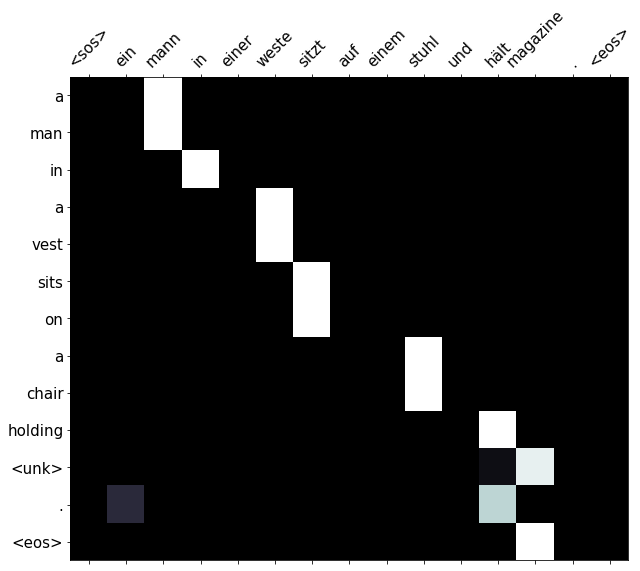

In [110]:
display_attention(src, translation, attention)

In [111]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']
trg = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']


predicted trg = ['a', 'woman', 'is', 'playing', 'a', 'song', 'on', 'her', 'violin', '.', '<eos>']


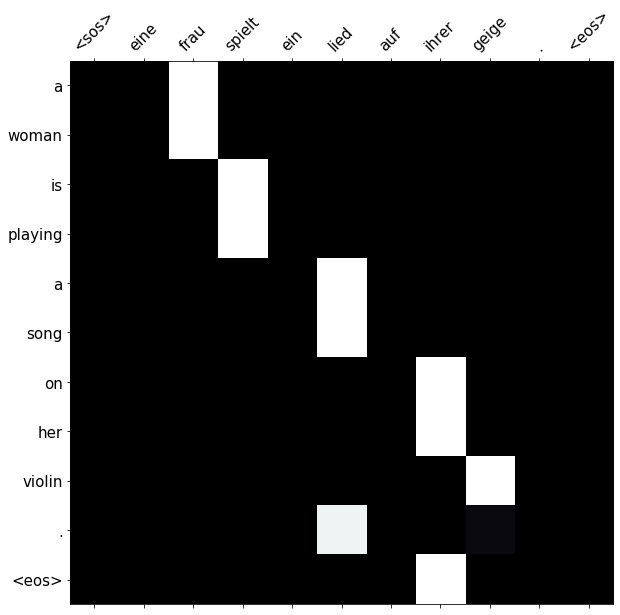

In [112]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [113]:
example_idx = 18

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['die', 'person', 'im', 'gestreiften', 'shirt', 'klettert', 'auf', 'einen', 'berg', '.']
trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'mountain', 'climbing', '.']


predicted trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'climbing', 'a', 'mountain', '.', '<eos>']


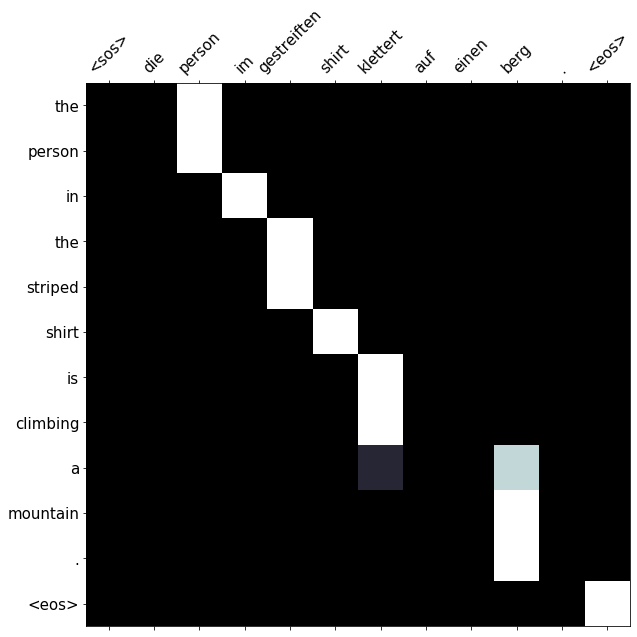

In [114]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [115]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [116]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 33.36
